## Evaluating regression techniques for speaker characterization
### Laura Fernández Gallardo

In this notebook, I will only only concentrate on the 'warmth' trait, while other notebooks deal with the detection of other characteristics and traits, or multi-output regression.

In [1]:
import io
import requests
import time # for timestamps

import numpy as np
import pandas as pd
from ast import literal_eval # parsing hp after tuner

from reg_tuning import * # my helper functions

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# fix random seed for reproducibility
seed = 2302
np.random.seed(seed)

## Load features and labels

In [3]:
path = 'https://raw.githubusercontent.com/laufergall/ML_Speaker_Characteristics/master/data/generated_data/'

url = path + "feats_ratings_scores_train.csv"
s = requests.get(url).content
feats_ratings_scores_train = pd.read_csv(io.StringIO(s.decode('utf-8')))

url = path + "feats_ratings_scores_test.csv"
s = requests.get(url).content
feats_ratings_scores_test = pd.read_csv(io.StringIO(s.decode('utf-8')))

with open(r'..\data\generated_data\feats_names.txt') as f:
    feats_names = f.readlines()
feats_names = [x.strip().strip('\'') for x in feats_names] 

with open(r'..\data\generated_data\items_names.txt') as f:
    items_names = f.readlines()
items_names = [x.strip().strip('\'') for x in items_names] 

with open(r'..\data\generated_data\traits_names.txt') as f:
    traits_names = f.readlines()
traits_names = [x.strip().strip('\'') for x in traits_names] 

## Model tuning with feature selection

Nested hyperparameter tuning with feature selection.

* Feature selection: SelectKBest(f_regression), tuning k
* RandomizedSearchCV on hyperparameters with uniform distribution, instead of grid search
* metric: neg_mean_squared_error

In [4]:
# Standardize speech features  

dropcolumns = ['name','spkID','speaker_gender'] + items_names + traits_names

# learn transformation on training data
scaler = StandardScaler()
scaler.fit(feats_ratings_scores_train.drop(dropcolumns, axis=1))

# numpy n_instances x n_feats
feats_s_train = scaler.transform(feats_ratings_scores_train.drop(dropcolumns, axis=1))
feats_s_test = scaler.transform(feats_ratings_scores_test.drop(dropcolumns, axis=1)) 

In [5]:
target_trait = traits_names[0]

In [6]:
X = feats_s_train # (2700, 88)
y = feats_ratings_scores_train[target_trait].as_matrix() # (2700,)

Xt = feats_s_test # (891, 88)
yt = feats_ratings_scores_test[target_trait].as_matrix() # (891,)

# split train data into 80% and 20% subsets - with balance in gender
# give subset A to the inner hyperparameter tuner
# and hold out subset B for meta-evaluation
AX, BX, Ay, By = train_test_split(X, y, test_size=0.20, stratify = feats_ratings_scores_train['speaker_gender'], random_state=2302)

print('Number of instances in A (hyperparameter tuning):',AX.shape[0])
print('Number of instances in B (meta-evaluation):',BX.shape[0])

Number of instances in A (hyperparameter tuning): 2160
Number of instances in B (meta-evaluation): 540


In [7]:
# save splits

# train/test partitions, features and labels
np.save(r'.\data_while_tuning\X_' + target_trait + '.npy', X)
np.save(r'.\data_while_tuning\y_' + target_trait + '.npy', y)
np.save(r'.\data_while_tuning\Xt_' + target_trait + '.npy', Xt)
np.save(r'.\data_while_tuning\yt_' + target_trait + '.npy', yt)

# # A/B splits, features and labels
np.save(r'.\data_while_tuning\AX_' + target_trait + '.npy', AX)
np.save(r'.\data_while_tuning\BX_' + target_trait + '.npy', BX)
np.save(r'.\data_while_tuning\Ay_' + target_trait + '.npy', Ay)
np.save(r'.\data_while_tuning\By_' + target_trait + '.npy', By)

In [8]:
# dataframe with results from hp tuner to be appended
tuning_all = pd.DataFrame()

# list with tuned classifiers trained on training data, to be appended
trained_all = []

### Calling hp_tuner() for each target and each regressor

** Recover ** when new ipynb session started.

(Workaround for working with hyperparameter tuning during several days)

In [ ]:
path = 'https://raw.githubusercontent.com/laufergall/ML_Speaker_Characteristics/master/data/generated_data/'

url = path + "feats_ratings_scores_train.csv"
s = requests.get(url).content
feats_ratings_scores_train = pd.read_csv(io.StringIO(s.decode('utf-8')))

url = path + "feats_ratings_scores_test.csv"
s = requests.get(url).content
feats_ratings_scores_test = pd.read_csv(io.StringIO(s.decode('utf-8')))

with open(r'..\data\generated_data\feats_names.txt') as f:
    feats_names = f.readlines()
feats_names = [x.strip().strip('\'') for x in feats_names] 

with open(r'..\data\generated_data\items_names.txt') as f:
    items_names = f.readlines()
items_names = [x.strip().strip('\'') for x in items_names] 

with open(r'..\data\generated_data\traits_names.txt') as f:
    traits_names = f.readlines()
traits_names = [x.strip().strip('\'') for x in traits_names] 

In [ ]:
# select a trait
# perform this on a loop later
target_trait = traits_names[0]

# train/test partitions, features and labels
X = np.load(r'.\data_while_tuning\X_' + target_trait + '.npy')
y = np.load(r'.\data_while_tuning\y_' + target_trait + '.npy')
Xt = np.load(r'.\data_while_tuning\Xt_' + target_trait + '.npy')
yt = np.load(r'.\data_while_tuning\yt_' + target_trait + '.npy')

# A/B splits, features and labels
AX = np.load(r'.\data_while_tuning\AX_' + target_trait + '.npy')
BX = np.load(r'.\data_while_tuning\BX_' + target_trait + '.npy')
Ay = np.load(r'.\data_while_tuning\Ay_' + target_trait + '.npy')
By = np.load(r'.\data_while_tuning\By_' + target_trait + '.npy')

In [ ]:
# Loading outpus of hp tuning from disk
tuning_all, trained_all = load_tuning(target_trait)

Call this after each experiment **to recover later**: 

In [ ]:
# save tuning_all (.csv) and trained_all (nameregressor.sav)
save_tuning(tuning_all, trained_all, target_trait)

#### Baseline regressor: mean


In [18]:
# baseline: predicts just the mean of the observations 
y_pred = np.mean(Ay)

# RMSE of baseline
myrmse = np.sqrt(mean_squared_error(By, np.repeat(y_pred, By.shape)))

print('%r -> root mean_squared_error on B set: %0.2f' % ('baseline', myrmse))   


'baseline' -> root mean_squared_error on B set: 1.82


#### K Nearest Neighbors

*class sklearn.neighbors.KNeighborsRegressor(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)*

Tuning number of neighbors. 'weights' and 'algorithm' don't make a big difference, so I leave them as default ('uniform' and 'auto', respectively).

In [26]:
from sklearn.neighbors import KNeighborsRegressor

"""
K Nearest Neighbors
"""
def get_KNeighborsRegressor2tune():

    model = KNeighborsRegressor()
    hp = dict(
        regressor__n_neighbors = list(range(1,10)),
        #regressor__weights = ['uniform','distance'],
        #regressor__algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
    )
    return 'KNeighborsRegressor', model, hp

k_array=np.arange(50, AX.shape[1])

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_KNeighborsRegressor2tune], 
                           target_trait,
                           feats_names,
                           k_array, 
                           'random',
                           n_iter=30
                          )


'KNeighborsRegressor' -> Best cross-val score on A set: -1.815684 using {'selecter__k': 64, 'regressor__n_neighbors': 4}
'KNeighborsRegressor' -> root mean_squared_error on B set: 1.240176



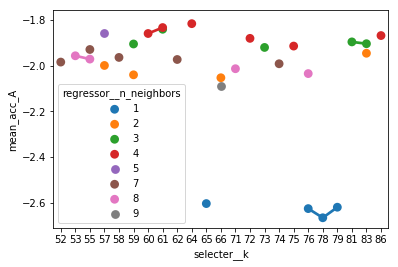

In [28]:
# open generated file with results of fitting GridSearchCV

sgrid = pd.read_csv(r'.\data_while_tuning\KNeighborsRegressor_'+target_trait+'_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()
#params_df['reg_params'] = params_df['regressor__algorithm'].values + params_df['regressor__weights'].values + params_df['regressor__n_neighbors'].values.astype(str)
#print(params_df.head())

# plot acc vs. params
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='regressor__n_neighbors', data=sgrid.join(params_df)) 

In [30]:
# update lists of tuning info and trained regressors
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

# save tuning_all (.csv) and trained_all (nameregressor.sav)
save_tuning(tuning_all, trained_all, target_trait)

#### Support Vector Machines

*class sklearn.svm.SVR(kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)*

For 'rbf': Tuning C (penalty of the error term) and gamma.

In [ ]:
from sklearn.svm import SVR

"""
Support Vector Machines with rbf kernel
"""
def get_SVRrbf2tune():
    
    model = SVR()
    hp = dict(
        regressor__C = np.logspace(1,4,num=4),
        regressor__kernel = ['rbf'], 
        regressor__gamma = np.logspace(-3,-1,num=3)
    )
    return 'SVRrbf', model, hp

k_array = np.arange(50, AX.shape[1]+1)

# tune with poly kernel
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_SVRrbf2tune], 
                           target_trait,
                           feats_names,
                           k_array, 
                           'random',
                           n_iter=15
                          )


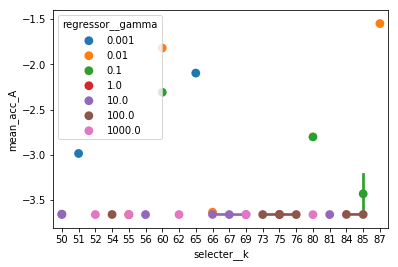

In [39]:
# open generated file with results of fitting GridSearchCV

sgrid = pd.read_csv(r'.\data_while_tuning\SVRrbf_'+target_trait+'_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()

# plot acc vs. params
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='regressor__gamma', data=sgrid.join(params_df)) 

In [40]:
np.logspace(-3,-1,num=3)

array([ 0.001,  0.01 ,  0.1  ])